In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [17]:
import cv2
import os
import sys
from typing import List, Dict, Optional
from pathlib import Path


In [ ]:
import importlib, config
importlib.reload(config)  

# 1. Make config importable
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..")) 
if base_dir not in sys.path:
    sys.path.append(base_dir)

try:
    from config import Config
except ImportError:
    raise ImportError("Could not import Config. Make sure config.py exists in your project root.")



In [26]:

# Path to your raw video folder
video_folder = Path(Config.RAW_DATA_DIR)  
if not video_folder.exists():
    raise FileNotFoundError(f"Video folder not found: {video_folder}")

# Collect all videos in this folder (no recursion)
video_files = [p for p in video_folder.iterdir() if p.suffix.lower() in Config.VIDEO_EXTS and p.is_file()]

print(f"Found {len(video_files)} video files in {video_folder}")


Found 25 video files in /mnt/d/git repositaries/ai-itms/data/raw


In [34]:
# Extract metadata
rows = []
for p in sorted(video_files):
    cap = cv2.VideoCapture(str(p))
    if not cap.isOpened():
        rows.append({
            "file_name": p.name,
            "fps": None,
            "frame_count": None,
            "duration_sec": None,
            "width": None,
            "height": None,
            "resolution": None,
            "file_size_mb": round(os.path.getsize(p) / (1024 * 1024), 3),
        })
        continue

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    cap.release()

    duration = (frame_count / fps) if (fps and fps > 0) else None


    file_size_mb = os.path.getsize(p) / (1024 * 1024)

    rows.append({
        "file_name": p.name,
        "fps": round(fps, 3) if fps and fps > 0 else None,
        "frame_count": int(frame_count) if frame_count >= 0 else None,
        "duration_sec": round(duration, 3) if duration is not None else None,
        "width": int(width) if width > 0 else None,
        "height": int(height) if height > 0 else None,
        "resolution": f"{int(width)}x{int(height)}" if width > 0 and height > 0 else None,
        "file_size_mb": round(file_size_mb, 3),
    })


In [35]:
# Create DataFrame and preview
df_videos = pd.DataFrame(rows)
print(df_videos.head())
print(f"Processed {len(df_videos)} videos")

# Save to CSV 
if hasattr(Config, "CLEAN_DATA_DIR"):
    os.makedirs(Config.CLEAN_DATA_DIR, exist_ok=True)
    csv_path = os.path.join(Config.CLEAN_DATA_DIR, "video_metadata.csv")
    df_videos.to_csv(csv_path, index=False)
    print(f"Saved video metadata to: {csv_path}")
else:
    print("Config.CLEAN_DATA_DIR not found. Skipping CSV save.")


                           file_name     fps  frame_count  duration_sec  \
0  VID_10_VID_20250716_152405697.mp4  27.212         3558       130.750   
1  VID_11_VID_20250716_154434474.mp4  29.533          671        22.720   
2  VID_12_VID_20250716_155450434.mp4  26.515         1913        72.147   
3  VID_13_VID_20250716_155636780.mp4  26.424          978        37.012   
4  VID_14_VID_20250716_155720057.mp4  26.153         9314       356.129   

   width  height resolution  file_size_mb  
0   3840    2160  3840x2160       758.061  
1   3840    2160  3840x2160        78.081  
2   3840    2160  3840x2160       361.882  
3   3840    2160  3840x2160       206.857  
4   3840    2160  3840x2160      1883.327  
Processed 25 videos
Saved video metadata to: /mnt/d/git repositaries/ai-itms/data/clean/video_metadata.csv


In [44]:
# Work on a copy so original stays intact
df_plot = df_videos.copy()

# Coerce numeric fields (in case any came in as objects)
num_cols = ["fps", "frame_count", "duration_sec", "width", "height", "file_size_mb"]
for c in num_cols:
    df_plot[c] = pd.to_numeric(df_plot[c], errors="coerce")


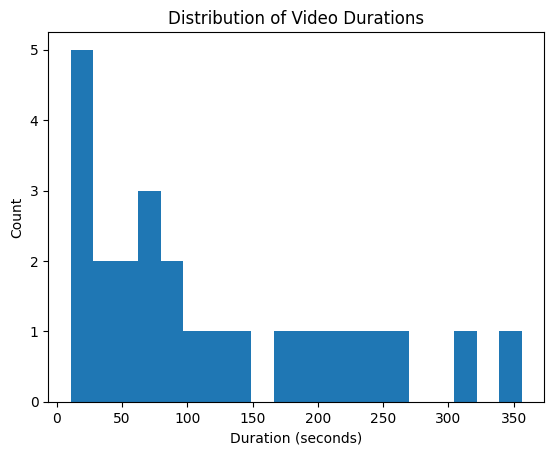

In [53]:
vals = df_plot["duration_sec"].dropna().values

plt.figure()
plt.hist(vals, bins=20)
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Distribution of Video Durations")
plt.show()


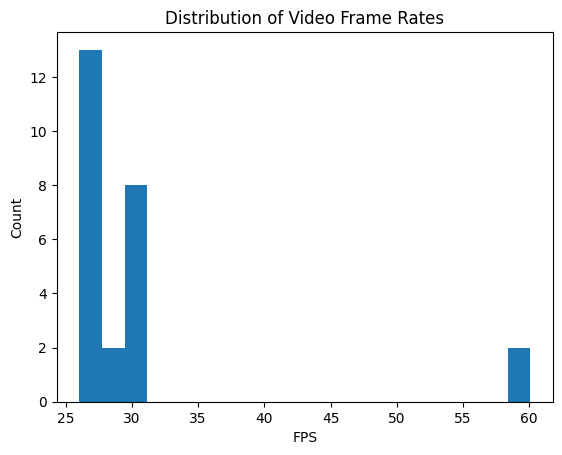

In [55]:
vals = df_plot["fps"].dropna().values

plt.figure()
plt.hist(vals, bins=20)
plt.xlabel("FPS")
plt.ylabel("Count")
plt.title("Distribution of Video Frame Rates")
plt.show()


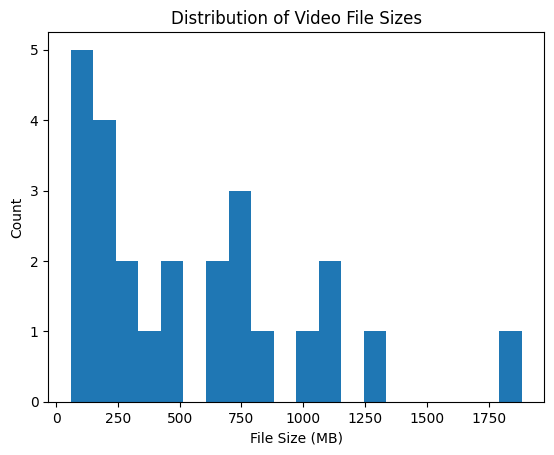

In [ ]:

vals = df_plot["file_size_mb"].dropna().values

plt.figure()
plt.hist(vals, bins=20)
plt.xlabel("File Size (MB)")
plt.ylabel("Count")
plt.title("Distribution of Video File Sizes")
plt.show()


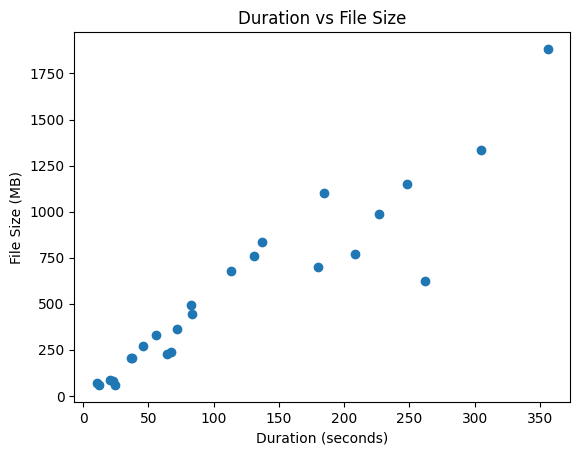

In [58]:
x = df_plot["duration_sec"].values
y = df_plot["file_size_mb"].values

plt.figure()
plt.scatter(x, y)
plt.xlabel("Duration (seconds)")
plt.ylabel("File Size (MB)")
plt.title("Duration vs File Size")
plt.show()


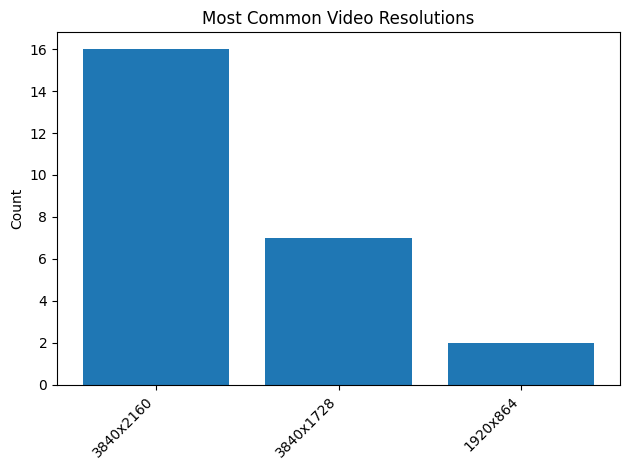

In [59]:
res_counts = (
    df_plot["resolution"]
    .dropna()
    .value_counts()
    .sort_values(ascending=False)
)

plt.figure()
plt.bar(res_counts.index.astype(str), res_counts.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.title("Most Common Video Resolutions")
plt.tight_layout()
plt.show()
